 ## Welcome 

In this notebook we are going to explore ASHRAE dataset with library plotly-express. Please feel free to clone or comment about any mistakes I have done.

In this competetion we are required to predict the energy consumption of different buildings given in the dataset.

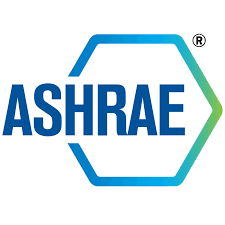

In [ ]:
# import the require libraries
import pandas as pd
import numpy as np
import os

import plotly_express as px
from plotly.offline import init_notebook_mode,iplot
from plotly import graph_objects as go
init_notebook_mode(connected=True)

Let's investigate the dataset!

There are 5 files namely train,test,building metadata, weather train, weather test. I believe train and test the files over we run the alogorithms.

But lets check how building metadata and weather can help

### Building Meta-Data

In [ ]:
df_meta = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
df_meta.head()

In [ ]:
df_meta.describe()

In [ ]:
df_meta.info()

We can see that there a lot of null values in floor count, so lets not take into much of conisderation

In [ ]:
tr1 = px.histogram(df_meta ,x = 'year_built',
                   marginal="violin",
                   title='Histogram of Number of building built in an year',
                   labels={'year_built':'Year'}, # can specify one label per df column
                   opacity=0.8,
#                     width=5000
                  )
tr1.show()

In [ ]:
df_meta_pri = df_meta.groupby('primary_use',as_index=False)['building_id'].count().rename(
    columns={'building_id':'n_buildings'}).sort_values('n_buildings',ascending=False)
tr2 = px.bar(
    df_meta_pri,
    title = 'No of bulidngs for each type',
    x = 'primary_use',
    y = 'n_buildings',
)
tr2.show()

In [ ]:
tr3 = px.histogram(df_meta ,x = 'square_feet',
                   marginal="violin",
                   title='Histogram of sq ft area of buildings',
                   labels={'square_feet':'Area in sq ft'}, # can specify one label per df column
                   opacity=0.8,
#                     width=5000
                  )
tr3.show()

In [ ]:
tr4 = px.scatter(df_meta, y="square_feet",
                 x="year_built", color="primary_use",
                 size="square_feet",
                 title = ""
                )
tr4.show()

More to come. Please wait

### Weather Data

In [ ]:
df_weather = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather['site_id'] = df_weather['site_id'].astype('str')

df_weather.head()

In [ ]:
tr5 = px.line(df_weather,
           x = "timestamp",
           y = "air_temperature",
           color = 'site_id',
#                  line_shape="spline"
       
          )
tr5.show()

As we can see there is definetly a seasonality in the weather features as expected. Now we need to find out how this effects on the electricity usage!

In [ ]:
df_train = pd.read_csv("../input/ashrae-energy-prediction/train.csv")
# df_test = pd.read_csv("../input/ashrae-energy-prediction/test.csv")

df_train.head()

In [ ]:
from fbprophet import Prophet

#### Simple prediction with fbprophet

lets select one of meter type in one of the building and try to predict using fbprophet without major parameter tuning

In [ ]:
df_train_10 = df_train[df_train['building_id'] == 10].reset_index(drop=True).rename(columns={'timestamp':'ds','meter_reading':'y'})

df_train_10['ds'] = pd.to_datetime(df_train_10['ds'])
print(f"No of unique meter types :{df_train_10['meter'].nunique()}")
df_train_10.head(2)


As there is only one meter type, we need not filter for a specific meter type again!

Let's create a sample test-train data set from the train dataset.

In [ ]:
n = 200
df_10_train = df_train_10.iloc[:-n]
df_10_test = df_train_10.iloc[-n:]

m = Prophet(yearly_seasonality=False,)
m.fit(df_10_train)
future = df_10_test[['ds']]

results = m.predict(future)

In [ ]:
fig = m.plot_components(results)

In [ ]:
results_new = pd.merge(results,df_10_test,on='ds',how='left')

In [ ]:
tr6 = go.Scatter(x=results_new.ds,
                y = results_new.yhat.values,name='preds')
tr7 = go.Scatter(x=results_new.ds,
                y = results_new.y.values,name='actuals')
tr8 = go.Scatter(x=results_new.ds,
                y = df_weather[df_weather['site_id'] == '0'].iloc[-n:]['air_temperature'].values)
print("Actuals vs Preds")
iplot([tr6,tr7])
print("Distribution of air temperature for the same time period")
iplot([tr8])

From the above charts we can see that there is a strong daily seasonality, And looks like there could be a relation between few metrics of weather to a respective meter type. Lets investigate on it as next step.



In [ ]:
del df_train

In [ ]:
df_weather

In [ ]:
df_weather_1 = df_weather[df_weather['site_id']=="1"]

In [ ]:
corr = df_weather_1.drop('precip_depth_1_hr',axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')